In [92]:
from netCDF4 import Dataset
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
from collections import defaultdict
from unpackConfigurationsMK import unpackConfigurationMK
import pandas as pd

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# SOLPS definitions

In [27]:
# bb
# * bb - (-1:nx,-1:ny,0:3) real*8 array.
# * For (ix,iy) in (-1:nx,-1:ny), bb(ix,iy,0:3) specifies the * magnetic field at the center of the (ix,iy) cell. 
# * bb(ix,iy,0:2) are the (x,y,z)-components and bb(ix,iy,3) is 
# * the absolute magnetic field strength. 
# * (bb(,,3)=sqrt(bb(,,0)**2+bb(,,1)**2+bb(,,2)**2.) 
# * It will hold that 0.lt.bb(,,3). 

# crx, cry
# crx, cry - (-1:nx,-1:ny,0:3) real*8 array.
# * For (ix,iy) in (-1:nx,-1:ny), crx(ix,iy,0:3) specify the
# * horizontal coordinates and cry(ix,iy,0:3) specify the vertical
# * coordinates (in the physical plane) of the four corners of the
# * (ix,iy) cell, mapped as follows:
# * (,,0): lower left corner, (,,1): lower right corner,
# * (,,2): upper left corner, (,,3): upper right corner.
# * One expects the following identities to hold away from the
# * boundaries:
# * crx(ix,iy,0)=crx(ix-1,iy,1)=crx(ix,iy-1,2)=crx(ix-1,iy-1,3),
# * cry(ix,iy,0)=cry(ix-1,iy,1)=cry(ix,iy-1,2)=cry(ix-1,iy-1,3),
# * However, there may be cuts in the geometry, in which case these
# * identities need not hold.

# Obtaining coordinates

In [121]:
File = r"C:\Users\Mike\OneDrive\Project\DLS\STEPv10\drsep0mm\balance_v10.nc"
Type = "outer"
returnSBool = True
sepadd=2
zxoverL=0.9
polModulator=1

rootgrp = Dataset(File, "r", format="NETCDF4")
sep = rootgrp['jsep'][0] # separatrix cell ring
sep = sep + sepadd # select cell ring to work on
bb = rootgrp["bb"] # B vector array

full = dict() # dictionary to store parameters over full SOL ring

full["Bpol"] = bb[0][sep]*polModulator

# bb[A] returns B components x, y, z and B magnitude for 
# A = 0, 1, 2 and 3 respectively for each cell centre in 2D grid
full["TotalField"] = bb[3][sep] # Mistake in Cyd's version. [3] is the total field

full["ne"] = rootgrp["ne"][sep]

# unpack dimensions of super-x
# both r and z have the same shape as bb
r = rootgrp['crx'] # corner radial coordinate (m)
z = rootgrp['cry'] # corner vertical coordinate (m)

# ring cell centres
full["R"] = np.mean([r[0][sep], r[1][sep], r[2][sep], r[3][sep]], axis = 0)
full["Z"] = np.mean([z[0][sep], z[1][sep], z[2][sep], z[3][sep]], axis = 0)

# Entire grid cell centres
Zs = np.mean([z[0], z[1], z[2], z[3]], axis = 0)
Rs = np.mean([r[0], r[1], r[2], r[3]], axis = 0)

gradR = np.gradient(full["R"])

len_R = len(full["R"])

## Coordinate order convention
For a single flux surface:
    - Start at bottom inner and go to upper inner
    - Switch to upper outer and go to lower outer

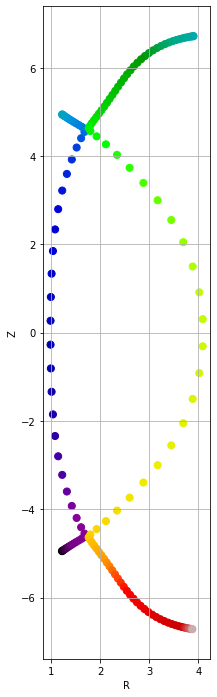

In [124]:
fig, ax = plt.subplots(figsize=(3,12))

cmap = plt.get_cmap("nipy_spectral")
colors = []
for i in range(len_R):
    i_scaled = int(i * 255 / len_R)
    colors.append(cmap(i_scaled))

s=50; marker = "o"
ax.scatter(full["R"], full["Z"], s = s, color = colors, marker = marker)
# ax.scatter(r[0], z[0], s = s, color = "black", marker = marker)
# ax.scatter(r[1], z[1], s = s, color = "red", marker = marker)
# ax.scatter(r[2], z[2], s = s, color = "green", marker = marker)
# ax.scatter(r[3], z[3], s = s, color = "blue", marker = marker)
ax.set_xlabel("R")
ax.set_ylabel("Z")
# ax.set_ylim(-7,-4)
# ax.set_ylim(-5,-4.5)
# ax.set_xlim(1.2,2.5)
# ax.set_ylim(-4.8, -4.7)
# ax.set_xlim(1.6,1.8)
ax.grid()

In [169]:
rootgrp["hx"]

<class 'netCDF4._netCDF4.Variable'>
float64 hx(ny_plus2, nx_plus2)
unlimited dimensions: 
current shape = (34, 148)
filling on, default _FillValue of 9.969209968386869e+36 used

(None, None)

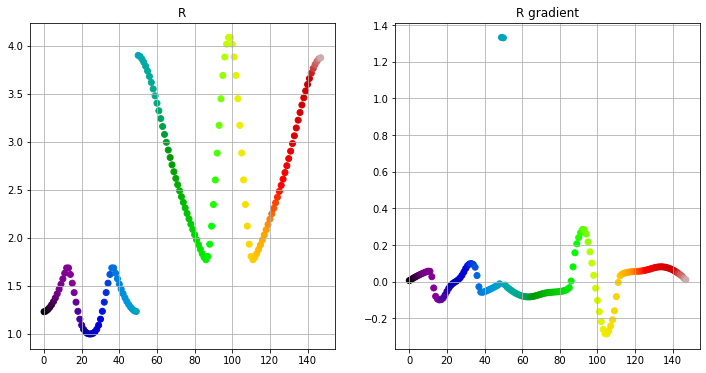

In [4]:
fig, ax = plt.subplots(1,2, figsize = (12,6))
ax[0].scatter(range(len_R), full["R"], color = colors); ax[0].set_title("R")
ax[1].scatter(range(len(gradR)), gradR, color = colors); ax[1].set_title("R gradient")
ax[0].grid(), ax[1].grid()

# Finding xpoint, midplane, edges

## Using gradients

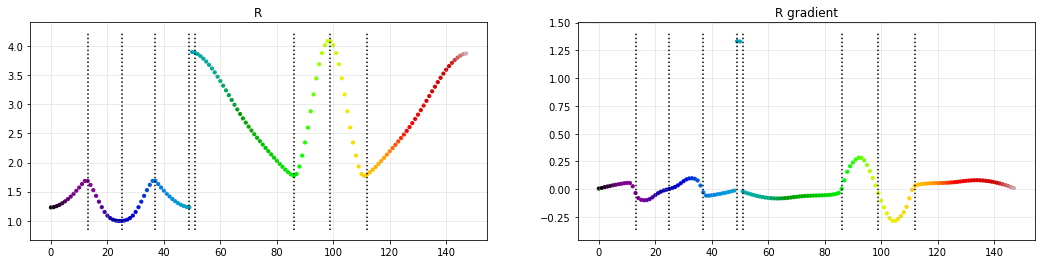

In [125]:
reversals = []
for i in range(1, len(gradR)):
    if np.sign(gradR[i-1]) != np.sign(gradR[i]):
        reversals.append(i)
        
fig, ax = plt.subplots(1,2, figsize = (18,4))
s = 10
ax[0].scatter(range(len_R), full["R"], color = colors, s = s); ax[0].set_title("R")
ax[1].scatter(range(len(gradR)), gradR, color = colors, s = s); ax[1].set_title("R gradient")

for i in [0,1]:
    ymin = ax[i].get_ylim()[0]; ymax = ax[i].get_ylim()[1]
    for reversal in reversals:
        ax[i].vlines(reversal, ymin, ymax, color = "black", linestyle = "dotted")
    ax[i].grid(which = "both", alpha = 0.3)


In [126]:
omp = reversals[-2] # outer midplane
imp = reversals[1] # inner midplane
xpoint = dict()
target = dict()
sol = defaultdict(dict)

xpoint["il"] = reversals[0] # inner lower xpoint
xpoint["iu"] = reversals[2] # outer upper xpoint
xpoint["ol"] = reversals[-1]-1 # outer lower xpoint
xpoint["ou"] = reversals[-3] # outer upper xpoint

target["il"] = 0
target["iu"] = reversals[3]+1
target["ou"] = reversals[4]-1
target["ol"] = len(gradR)

sol["il"]["R"] = full["R"][target["il"]:imp+1]
sol["iu"]["R"] = full["R"][imp-1:target["iu"]]
sol["ou"]["R"] = full["R"][target["ou"]:omp+1]
sol["ol"]["R"] = full["R"][omp-1:target["ol"]]

sol["il"]["Z"] = full["Z"][target["il"]:imp+1]
sol["iu"]["Z"] = full["Z"][imp-1:target["iu"]]
sol["ou"]["Z"] = full["Z"][target["ou"]:omp+1]
sol["ol"]["Z"] = full["Z"][omp-1:target["ol"]]
                      
start = dict(); end = dict()
start["il"] = target["il"]
start["iu"] = imp-1
start["ou"] = target["ou"]
start["ol"] = omp-1

end["il"] = imp+1
end["iu"] = target["iu"]
end["ou"] = omp+1
end["ol"] = target["ol"]
    
# Extract the four SOLs using their starts and ends
sol = defaultdict(dict) # Dict of parameters in each SOL side. sol[param][side]

for param in full.keys():
    for side in ["il", "iu", "ou", "ol"]:
        sol[param][side] = full[param][start[side]:end[side]]

# Invert inner lower and outer upper so that all SOLs 
# start at their midplane and end at their target
for param in full.keys():
    sol[param]["il"] = sol[param]["il"][::-1]
    sol[param]["ou"] = sol[param]["ou"][::-1]

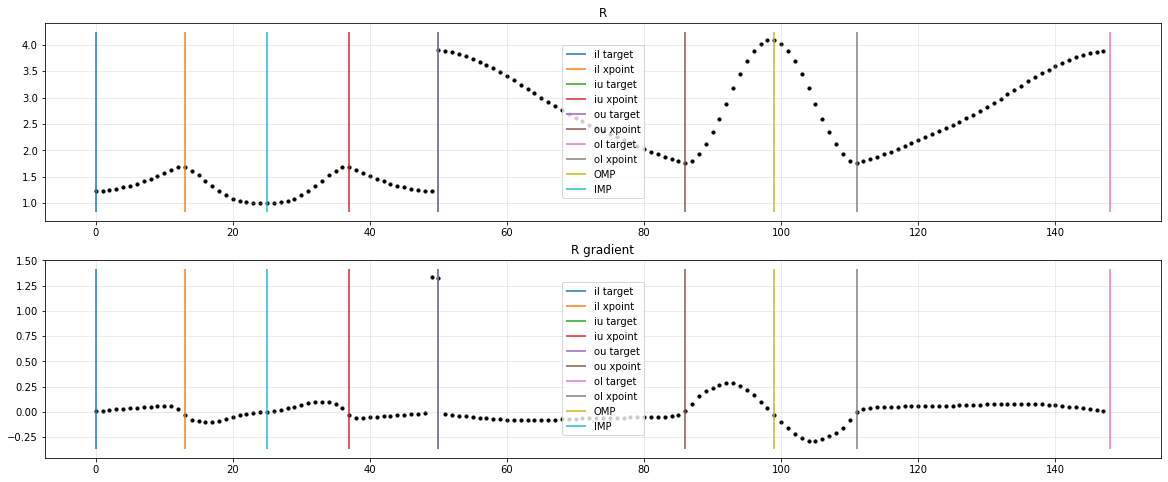

In [127]:

fig, ax = plt.subplots(2,1, figsize = (20,8))
s = 10
ax[0].scatter(range(len_R), full["R"], s = s, color = "black"); ax[0].set_title("R")
ax[1].scatter(range(len(gradR)), gradR, s = s, color = "black"); ax[1].set_title("R gradient")

cmap = plt.get_cmap("tab10")
catcolors = [cmap(x) for x in range(10)]

for i in [0,1]:
    
    ymin = ax[i].get_ylim()[0]; ymax = ax[i].get_ylim()[1]
    
    colorcounter = 0 
    
    for side in ["il", "iu", "ou", "ol"]:
        ax[i].vlines(target[side], ymin, ymax, label = f"{side} target", color = catcolors[colorcounter])
        colorcounter += 1
        ax[i].vlines(xpoint[side], ymin, ymax, label = f"{side} xpoint", color = catcolors[colorcounter])
        colorcounter += 1
        
    ax[i].vlines(omp, ymin, ymax, label = f"OMP", color = catcolors[-2])
    ax[i].vlines(imp, ymin, ymax, label = f"IMP", color = catcolors[-1])
    ax[i].grid(which = "both", alpha = 0.3)

    ax[i].legend(loc="center")

- Somehow the edges above aren't picked up - please treat the bottom graph (edge check) as truth.

Text(0.5, 0.98, 'Check on edges')

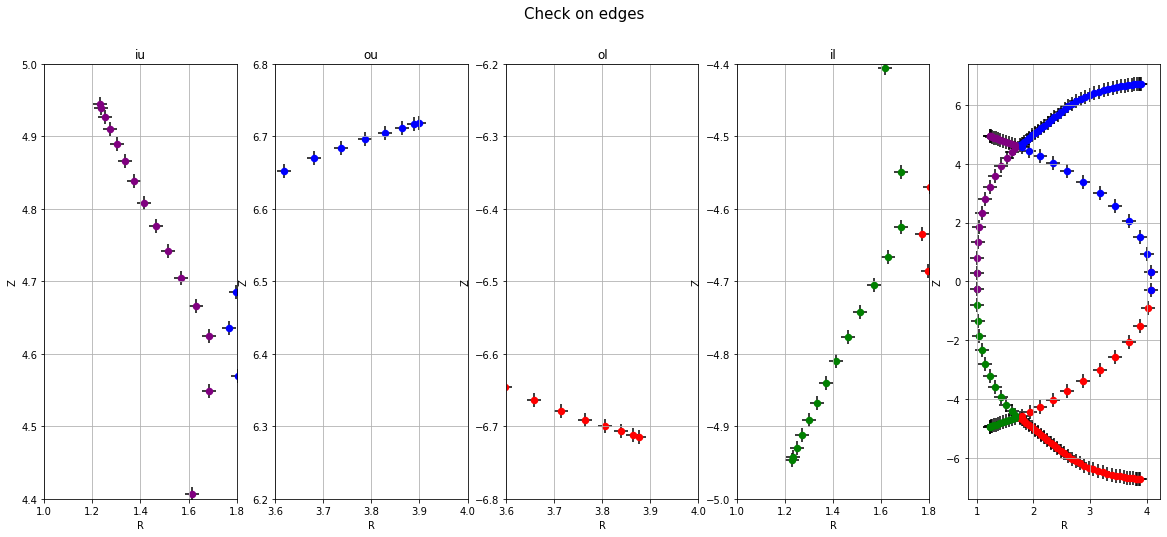

In [128]:
# %matplotlib widget
fig, axes = plt.subplots(1,5, figsize=(20,8))

colors = []
for i in range(len_R):
    i_scaled = int(i * 255 / len_R)
    colors.append(cmap(i_scaled))

s=50; marker = "o"

for ax in axes:
    

    c = ["red", "green", "blue", "purple"]

    for i, side in enumerate(["ol", "il", "ou", "iu"]):
        ax.scatter(sol["R"][side], sol["Z"][side], color = c[i], linewidth = 2, alpha = 1, marker = "o", zorder = 1, s = 30)
        
    ax.scatter(full["R"], full["Z"], s = 200, edgecolors = "black", marker = "+", c="black", alpha = 1, zorder = 0)

    ax.set_xlabel("R")
    ax.set_ylabel("Z")
    ax.grid()
    
axes[0].set_ylim(4.4,5)
axes[0].set_xlim(1,1.8)

axes[1].set_ylim(6.2,6.8)
axes[1].set_xlim(3.6,4)

axes[2].set_ylim(-6.8,-6.2)
axes[2].set_xlim(3.6,4)

axes[3].set_ylim(-5,-4.4)
axes[3].set_xlim(1,1.8)

axes[0].set_title("iu")
axes[1].set_title("ou")
axes[2].set_title("ol")
axes[3].set_title("il")
plt.suptitle("Check on edges", fontsize = 15)
# ax.set_ylim(-5,-4.5)
# ax.set_xlim(1.2,2.5)
# ax.set_ylim(-4.8, -4.7)
# ax.set_xlim(1.6,1.8)

# %matplotlib inline

## Using leftix

- More general way to get the x-point and break between inner and outer than just the gradients
- Based on David Moulton's MATLAB script

In [25]:
len_R

148

### Getting breaks

In [79]:
# Find the X-points, edges and midpoints
# SOLPS draws grid clockwise from inner lower target
# leftix returns x-coordinate of neighbouring "downstream" cell
# if leftix jumps by more than 1, this indicates a discontinuity
# In a CDN scenario this is the xpoints and the jump from the upper
# inner to upper outer targets.

breaks = []
leftix = rootgrp["leftix"][sep]
diff_leftix = np.diff(leftix)

for i in range(len_R):
    if diff_leftix[i-1] > 1:
        breaks.append(i-1)

### Getting key points 

In [25]:
xpoint = dict(); target = dict()
start = dict(); end = dict()

# Manually assign xpoints and targets based on breaks in the global SOL coordinate space
xpoint["il"] = breaks[0]+1
xpoint["iu"] = breaks[1] 
xpoint["ol"] = breaks[3]-1 
xpoint["ou"] = breaks[4]

target["il"] = 0
target["iu"] = breaks[2]-1
target["ou"] = breaks[2]
target["ol"] = len(leftix)

# Find midplanes by gradient sign change inbetween the x-points found above
gradientR = np.gradient(full["R"])

for i in range(xpoint["il"], xpoint["iu"]):
    if np.sign(gradientR[i]) != np.sign(gradientR[i+1]):
        imp = i

for i in range(xpoint["ol"], xpoint["ou"]):
    if np.sign(gradientR[i]) != np.sign(gradientR[i+1]):
        omp = i

# Assign the beginning and end of each SOL segment
# We are still going clockwise from bottom left
start["il"] = target["il"]
start["iu"] = imp 
start["ou"] = target["ou"]
start["ol"] = omp 

end["il"] = imp + 2
end["iu"] = target["iu"]
end["ou"] = omp + 2
end["ol"] = target["ol"]

# Extract the four SOLs using their starts and ends
sol = defaultdict(dict) # Dict of parameters in each SOL side. sol[param][side]

for param in full.keys():
    for side in ["il", "iu", "ou", "ol"]:
        sol[param][side] = full[param][start[side]:end[side]]

# Invert inner lower and outer upper so that all SOLs 
# start at their midplane and end at their target
for param in full.keys():
    sol[param]["il"] = sol[param]["il"][::-1]
    sol[param]["ou"] = sol[param]["ou"][::-1]

- Reverse the SOL sides so each always starts from its midplane

#### Side direction test

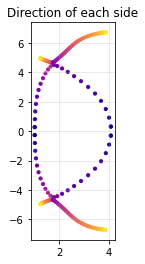

In [142]:
fig, ax = plt.subplots(figsize = (1.5,4))

ax.set_title("Direction of each side")
cmap = plt.get_cmap("plasma")

for side in ["il", "iu", "ou", "ol"]:
    colors = []
    for i in range(len(sol["R"][side])):     
        i_scaled = int(i * 255 / len(sol["R"][side]))
        colors.append(cmap(i_scaled))
    ax.scatter(sol["R"][side], sol["Z"][side], s = 10, color = colors) 
                             
ax.grid(which = "both", alpha = 0.3)

#### Key points test

- Let's make sure that all of the key points are correctly found
- Note that there is no cell exactly on the midplane so the selections cannot be central
- This is resolved by going one cell too far on each side and the interpolating to the middle later

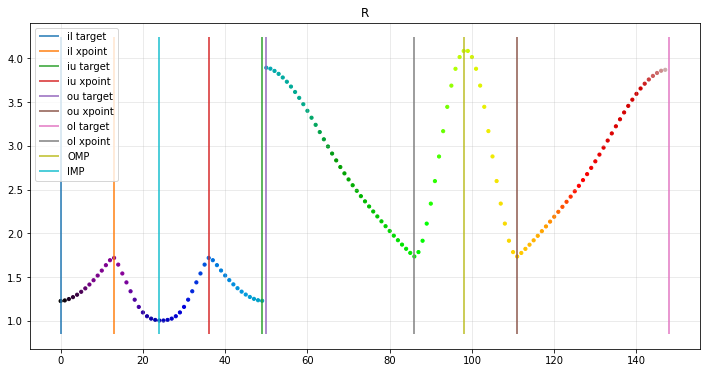

In [173]:
fig, ax = plt.subplots(figsize = (12,6))
s = 10

cmap_nipy = plt.get_cmap("nipy_spectral")
colors_nipy = []
for i in range(len_R):
    i_scaled = int(i * 255 / len_R)
    colors_nipy.append(cmap_nipy(i_scaled))
    
ax.scatter(range(len_R), full["R"], s = s, color = colors_nipy) 
ax.set_title("R")

cmap = plt.get_cmap("tab10")
catcolors = [cmap(x) for x in range(10)]
ymin = ax.get_ylim()[0]; ymax = ax.get_ylim()[1]

colorcounter = 0 
for side in ["il", "iu", "ou", "ol"]:
    ax.vlines(target[side], ymin, ymax, label = f"{side} target", color = catcolors[colorcounter])
    colorcounter += 1
    ax.vlines(xpoint[side], ymin, ymax, label = f"{side} xpoint", color = catcolors[colorcounter])
    colorcounter += 1

ax.vlines(omp, ymin, ymax, label = f"OMP", color = catcolors[-2])
ax.vlines(imp, ymin, ymax, label = f"IMP", color = catcolors[-1])

# for i in breaks:
#     ax.vlines(i, ymin, ymax, color = "black", linestyle = "dotted")
    
ax.grid(which = "both", alpha = 0.3)

ax.legend()

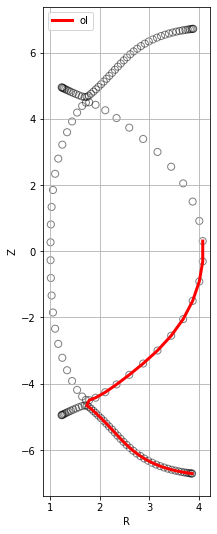

In [215]:
fig, ax = plt.subplots(figsize=(3,9))

colors = []
for i in range(len_R):
    i_scaled = int(i * 255 / len_R)
    colors.append(cmap(i_scaled))

s=50; marker = "o"
ax.scatter(full["R"], full["Z"], s = s, edgecolors = "black", marker = marker, c="None", alpha = 0.5 )

c = ["red", "green", "blue", "purple"]
s = ["solid", "solid", "dashed", "dashed"]

# for i, side in enumerate(["ol", "il", "ou", "iu"]):
for i, side in enumerate(["ol"]):
    ax.plot(sol["R"][side], sol["Z"][side], color = c[i], linewidth = 3, linestyle = s[i], label = side)
    
ax.legend()
ax.set_xlabel("R")
ax.set_ylabel("Z")
ax.grid()

# Interpolation

In [129]:
# Functions taken directly from Cyd

def returnll(R,Z):
    #return the poloidal distances from the target for a given configuration
    PrevR = R[0]
    ll = []
    currentl = 0
    PrevZ = Z[0]
    for i in range(len(R)):
        dl = np.sqrt((PrevR-R[i])**2 + (PrevZ-Z[i])**2)
        currentl = currentl+ dl
        ll.append(currentl)
        PrevR = R[i]
        PrevZ = Z[i]
    return ll

def returnS(R,Z,B,Bpol):
    #return the real total distances from the target for a given configuration
    PrevR = R[0]
    s = []
    currents = 0
    PrevZ = Z[0]
    for i in range(len(R)):
        dl = np.sqrt((PrevR-R[i])**2 + (PrevZ-Z[i])**2)
        ds = dl*np.abs(B[i])/np.abs(Bpol[i])
        currents = currents+ ds
        s.append(currents)
        PrevR = R[i]
        PrevZ = Z[i]
    return s

def returnzl(R,Z, BX, Bpol):
    # return the distance in z from the target for a given configuration
    PrevR = R[0]
    PrevZ = Z[0]
    CurrentZ = 0
    zl = []
    for i in range(len(R)):
        dl = np.sqrt((PrevR-R[i])**2 + (PrevZ-Z[i])**2)
        dz = dl*BX/(Bpol[i])
        CurrentZ = CurrentZ+ dz
        zl.append(CurrentZ)
        PrevR = R[i]
        PrevZ = Z[i]
    return zl

- You need to interpolate to the midplane

In [130]:
path_actual = dict() # distances between cells from file
path_grid = dict() # grid to interpolate over
interp = defaultdict(dict) # dict of interpolators
data = defaultdict(dict) # final parameters

for side in ["ol", "il", "ou", "iu"]:
    path_actual[side] = returnll(sol["R"][side], sol["Z"][side])

# Find length between the two midplane cells so that we can interpolate from in-between them
# Done by looking at first path length of the inner upper and final length of the outer upper
# This works because the cells are in a clockwise order, therefore il -> iu -> ou -> ol
imp_len = path_actual["iu"][1] - path_actual["iu"][0]
omp_len = path_actual["ou"][1] - path_actual["ou"][0]

# Offset the actual paths so they're zero at the actual midplane inbetween the two cells there
# Then make grids to interpolate on that start at zero and end at the path end
for side in ["iu", "il"]:
    path_actual[side] -= imp_len/2
    path_grid[side] = np.linspace(0, np.amax(path_actual[side]), 10000)

for side in ["ou", "ol"]:
    path_actual[side] -= omp_len/2
    path_grid[side] = np.linspace(0, np.amax(path_actual[side]), 10000)

# Create interpolators and apply them
for side in ["ol", "il", "ou", "iu"]:
    for param in full.keys():
        interp[side][param] = interpolate.interp1d(path_actual[side], sol[param][side], kind = "cubic")
        data[side][param] = interp[side][param](path_grid[side])


## Find xpoints again

In [131]:
# Find Xpoints again in the interpolated grid using gradient sign change
# Stores xpoint index valid for each local divertor SOL space
for side in ["ol", "il", "ou", "iu"]:
    gradientR = np.gradient(data[side]["R"])

    for i in range(len(gradientR)-1):
        if np.sign(gradientR[i]) != np.sign(gradientR[i+1]):
            data[side]["Xpoint"] = i-1

Text(0, 0.5, 'Z')

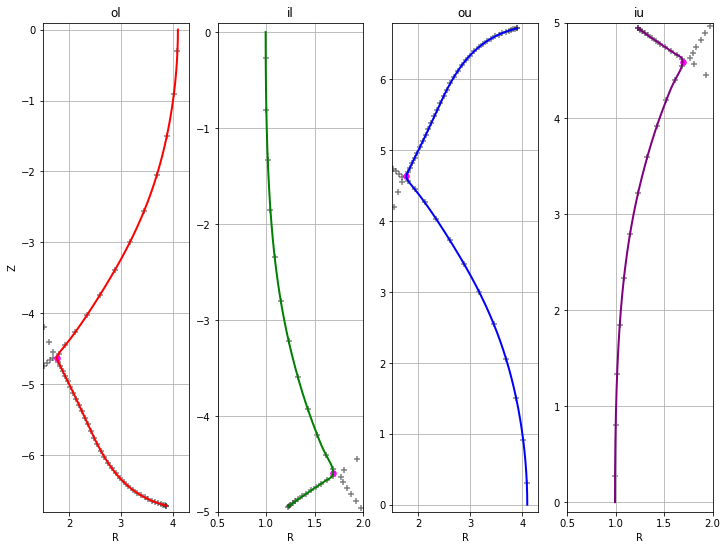

In [132]:
fig, ax = plt.subplots(1,4, figsize=(12,9))

colors = []
for i in range(len_R):
    i_scaled = int(i * 255 / len_R)
    colors.append(cmap(i_scaled))

s=80; marker = "o"
c = ["red", "green", "blue", "purple"]
 
for i, side in enumerate(["ol", "il", "ou", "iu"]):
    d = data[side]
    ax[i].scatter(full["R"], full["Z"], s = 40, edgecolors = "black", marker = "+", c="black", alpha = 0.5)
    ax[i].plot(d["R"], d["Z"],  c=c[i], alpha = 1, linewidth = 2)
    ax[i].scatter(d["R"][d["Xpoint"]], d["Z"][d["Xpoint"]], color = "magenta", marker = "o", s = 30)
    ax[i].set_title(side)
    ax[i].set_xlabel("R")
    ax[i].grid()
    
ax[0].set_xlim(1.5,4.3)
ax[0].set_ylim(-6.8,0.1)
ax[1].set_xlim(0.5,2)
ax[1].set_ylim(-5,0.1)

ax[2].set_xlim(1.5,4.3)
ax[2].set_ylim(-0.1,6.8)

ax[3].set_xlim(0.5,2)
ax[3].set_ylim(-0.1,5)
ax[0].set_ylabel("Z")

In [135]:
zl = dict() # Z space path
Bx = dict() # Btot at Xpoint
polLengthArray = dict() # another poloidal distance path but now of the interpolated SOLs
S = dict() # Real distance path as opposed to poloidal distance


for side in ["ol", "il", "ou", "iu"]:
    d = data[side]
    d["Bx"] = d["TotalField"][d["Xpoint"]]
    d["zl"] = np.array(returnzl(d["R"], d["Z"], d["Bx"], np.absolute(d["Bpol"])))
    d["zx"] = d["zl"][d["Xpoint"]]
    d["polLengthArray"] = np.array(returnll(d["R"], d["Z"]))
    d["S"] = returnS(d["R"], d["Z"], d["TotalField"], d["Bpol"])

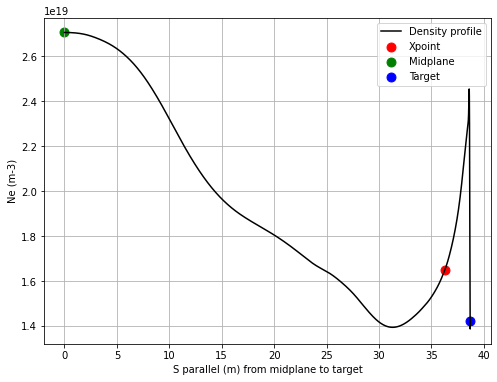

In [150]:
fig, ax = plt.subplots(figsize = (8,6))


ax.plot(data["ol"]["S"], data["ol"]["ne"], color = "black", label = "Density profile")
ax.scatter(data["ol"]["S"][d["Xpoint"]], data["ol"]["ne"][d["Xpoint"]], color = "red", label = "Xpoint", zorder = 1, s = 80)
ax.scatter(data["ol"]["S"][0], data["ol"]["ne"][0], color = "green", label = "Midplane", zorder = 1, s = 80)
ax.scatter(data["ol"]["S"][-1], data["ol"]["ne"][-1], color = "blue", label = "Target", zorder = 1, s = 80)
ax.set_ylabel("Ne (m-3)")
ax.set_xlabel("S parallel (m) from midplane to target")
ax.legend()
ax.grid()


# Function tests

In [43]:
d.keys()

dict_keys(['Bpol', 'Btot', 'R', 'Z', 'Xpoint', 'Bx', 'zl', 'zx', 'Spol', 'S', 'R_full', 'Z_full', 'R_ring', 'Z_ring'])

Text(0, 0.5, 'Z')

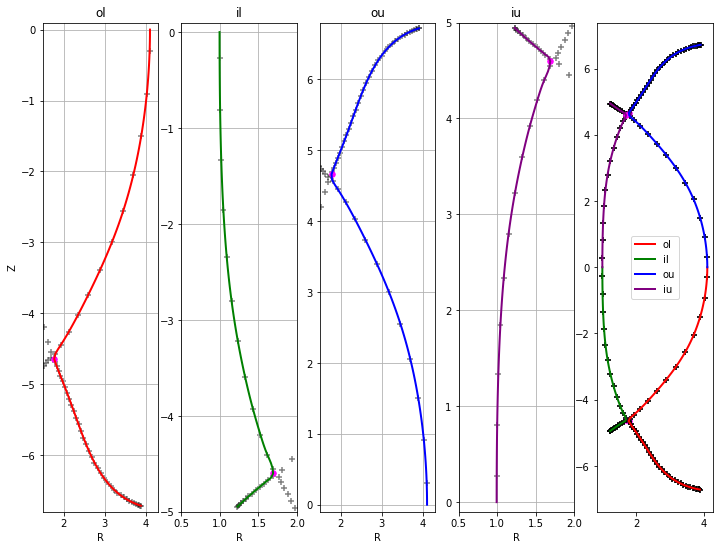

In [104]:
gridFile = r"C:\Users\Mike\OneDrive\Project\DLS\STEPv10\drsep0mm\balance_v10.nc"
sepadd = 2
data = dict()

fig, ax = plt.subplots(1,5, figsize=(12,9))

s=80; marker = "o"
c = ["red", "green", "blue", "purple"]
 
for i, side in enumerate(["ol", "il", "ou", "iu"]):
    data[side] = unpackConfigurationMK(File = gridFile, Type =side, sepadd=sepadd, resolution = 100, 
                                       convention = "midplane_to_target")
    d = data[side]
    ax[i].scatter(d["R_ring"], d["Z_ring"], s = 40, edgecolors = "black", marker = "+", c="black", alpha = 0.5)
    ax[i].plot(d["R"], d["Z"],  c=c[i], alpha = 1, linewidth = 2)
    ax[i].scatter(d["R"][d["Xpoint"]], d["Z"][d["Xpoint"]], color = "magenta", marker = "o", s = 30)
    ax[i].set_title(side)
    ax[i].set_xlabel("R")
    ax[i].grid()
    
    ax[4].scatter(d["R_ring"], d["Z_ring"], s = 40, edgecolors = "black", marker = "+", c="black", alpha = 0.5)
    ax[4].plot(d["R"], d["Z"],  c=c[i], alpha = 1, linewidth = 2, label = side)
    ax[4].scatter(d["R"][d["Xpoint"]], d["Z"][d["Xpoint"]], color = "magenta", marker = "o", s = 30)
    ax[4].legend(); ax[4].grid(); 
    
ax[0].set_xlim(1.5,4.3)
ax[0].set_ylim(-6.8,0.1)
ax[1].set_xlim(0.5,2)
ax[1].set_ylim(-5,0.1)

ax[2].set_xlim(1.5,4.3)
ax[2].set_ylim(-0.1,6.8)

ax[3].set_xlim(0.5,2)
ax[3].set_ylim(-0.1,5)
ax[0].set_ylabel("Z")

In [86]:
d.keys()

dict_keys(['Bpol', 'Btot', 'R', 'Z', 'Xpoint', 'Bx', 'zl', 'zx', 'Spol', 'S', 'R_full', 'Z_full', 'R_ring', 'Z_ring'])

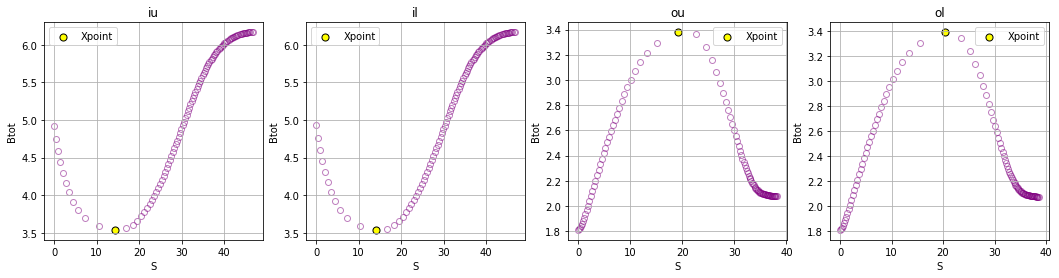

In [112]:
gridFile = r"C:\Users\Mike\OneDrive\Project\DLS\STEPv10\drsep0mm\balance_v10.nc"
sepadd = 2
data = dict()

fig, ax = plt.subplots(1,4, figsize = (18,4))

xparam = "S"
yparam = "Btot"

for i, side in enumerate(["iu", "il", "ou", "ol"]):
    data[side] = unpackConfigurationMK(File = gridFile, Type =side, sepadd=sepadd, resolution = 100, 
                                       # convention = "midplane_to_target")
                                       convention = "target_to_midplane", diagnostic_plot = True)
    d = data[side]
    Xpoint = d["Xpoint"]
    ax[i].set_title(side)
    ax[i].plot(d[xparam], d[yparam], marker = "o", color = "None", markerfacecolor = "None", markeredgecolor = "purple", alpha = 0.5, zorder = 0)
    ax[i].scatter(d[xparam][Xpoint], d[yparam][Xpoint], marker = "o", s = 50, edgecolor = "black", color = "yellow", label = "Xpoint", zorder = 1)
    ax[i].legend(); ax[i].grid()
    ax[i].set_xlabel(xparam); ax[i].set_ylabel(yparam)

# Function check

In [114]:
gridFile = r"C:\Users\Mike\OneDrive\Project\DLS\STEPv10\drsep0mm\balance_v10.nc"
sepadd = 2

data = dict()
data["iu"] = unpackConfigurationMK(File = gridFile, Type ="iu", sepadd=sepadd)
data["ou"] = unpackConfigurationMK(File = gridFile, Type ="ou", sepadd=sepadd)

In [ ]:
fig, ax = plt.subplots(1,4, figsize=(12,9))

colors = []
for i in range(len_R):
    i_scaled = int(i * 255 / len_R)
    colors.append(cmap(i_scaled))

s=80; marker = "o"
c = ["red", "green", "blue", "purple"]
 
for i, side in enumerate(["ol", "il", "ou", "iu"]):
    d = data[side]
    ax[i].scatter(full["R"], full["Z"], s = 40, edgecolors = "black", marker = "+", c="black", alpha = 0.5)
    ax[i].plot(d["R"], d["Z"],  c=c[i], alpha = 1, linewidth = 2)
    ax[i].scatter(d["R"][d["Xpoint"]], d["Z"][d["Xpoint"]], color = "magenta", marker = "o", s = 30)
    ax[i].set_title(side)
    ax[i].set_xlabel("R")
    ax[i].grid()
    
ax[0].set_xlim(1.5,4.3)
ax[0].set_ylim(-6.8,0.1)
ax[1].set_xlim(0.5,2)
ax[1].set_ylim(-5,0.1)

ax[2].set_xlim(1.5,4.3)
ax[2].set_ylim(-0.1,6.8)

ax[3].set_xlim(0.5,2)
ax[3].set_ylim(-0.1,5)
ax[0].set_ylabel("Z")

# Other variables

In [ ]:
# * (Let fhex(,)=fhe(,,0) and fhey(,)=fhe(,,1).)
# * For (ix,iy) in (0:nx,-1:ny), fhex(ix,iy) specifies the electron
# * heat flux through the face between the (ix,iy) cell and
# * its left neighbor. For ix.eq.-1, fhex(ix,-1:ny) will hold 0.
# * For (ix,iy) in (-1:nx,0:ny), fhey(ix,iy) specifies the electron
# * heat flux through the face between the (ix,iy) cell and
# * its bottom neighbor. For iy.eq.-1, fhey(-1:nx,iy) will hold 0.
# **
# fhe_mdf - (-1:nx,-1:ny,0:1) real*8 array.
# * (Let fhex_mdf(,)=fhe_mdf(,,0) and fhey_mdf(,)=fhe_mdf(,,1).)
# * For (ix,iy) in (0:nx,-1:ny), fhex_mdf(ix,iy) specifies the modified
# * electron heat flux through the face between the (ix,iy) cell
# * and its left neighbor. For ix.eq.-1, fhex_mdf(ix,-1:ny) will hold 0.
# * For (ix,iy) in (-1:nx,0:ny), fhey_mdf(ix,iy) specifies the modified
# * electron heat flux through the face between the (ix,iy) cell and
# * its bottom neighbor. For iy.eq.-1, fhey_mdf(-1:nx,iy) will hold 0.
# * fhe_mdf is equal fhe for runs without drifts.
# **
# fhi - (-1:nx,-1:ny,0:1) real*8 array.
# * (Let fhix(,)=fhi(,,0) and fhiy(,)=fhi(,,1).)
# * For (ix,iy) in (0:nx,-1:ny), fhix(ix,iy) specifies the all atom
# * heat flux through the face between the (ix,iy) cell
# * and its left neighbor. For ix.eq.-1, fhix(ix,-1:ny) will hold 0.
# * For (ix,iy) in (-1:nx,0:ny), fhiy(ix,iy) specifies the all atom
# * heat flux through the face between the (ix,iy) cell and its
# * bottom neighbor. For iy.eq.-1, fhiy(-1:nx,iy) will hold 0.

# * ne - (-1:nx,-1:ny) real*8 array.
# * For (ix,iy) in (-1:nx,-1:ny), ne(ix,iy) specifies the electron
# * density on the (ix,iy) cell. It will hold that 0.lt.ne(,).
# * The defining expression for ne is
# * ne(,) = (sum is : 0.le.is.lt.ns : rza(,,is)*na(,,is)).

In [123]:
fhex = rootgrp["fhe_mdf"] 

IndexError: fhe_mdf not found in /

In [120]:
rootgrp["ne"]

<class 'netCDF4._netCDF4.Variable'>
float64 ne(ny_plus2, nx_plus2)
unlimited dimensions: 
current shape = (34, 148)
filling on, default _FillValue of 9.969209968386869e+36 used